In [1]:
!pip install pyclesperanto_prototype 

In [1]:
from skimage import io
import matplotlib.pyplot as plt
import scanpy
import numpy as np
import cupy as cp
import pyclesperanto_prototype as cle
cle.select_device('cuda')
from cupyx.scipy import ndimage
import os
import time
import pickle
import pandas as pd

In [2]:
trimms={'ADmouse_9494':[(13,312),(22356,22521)],'ADmouse_9498':[(690,162),(19641,22515)],'ADmouse_9723':[(92,191),(19643,22484)],'ADmouse_9735':[(22,71),(19637,22522)]}
voxel_size_x = 0.0946
voxel_size_y = 0.0946
voxel_size_z = 0.3463

s='ADmouse_9498'
sname='control13'
img=io.imread('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/'+s+'/pi.tif')
img=img[:,trimms[s][0][1]:(trimms[s][1][1]+1),trimms[s][0][0]:(trimms[s][1][0]+1)]

In [3]:
#crop full image into patches with centered on each cell
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

gaeCoord=None
sampleNames=None
celltype_broad=None
celltype_sub=None
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
for s in plot_samples.keys():
    sampleidx_s=plot_samples[s] 
    if gaeCoord is None:
        gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
        celltype_broad=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()
        celltype_sub=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()
    else:
        gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
        celltype_broad=np.concatenate((celltype_broad,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['top_level']].to_numpy()))
        celltype_sub=np.concatenate((celltype_sub,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['cell_type_label']].to_numpy()))
celltype_broad=celltype_broad.flatten()
gaeCoord=(gaeCoord/0.3).astype(int)
#by samples
gaeCoord=gaeCoord[sampleNames==sname]
scaleddata=None

In [4]:
gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.1epoch9990'
with open(gaeClusterPath, 'rb') as input:
    gaeclusterlabels = pickle.load(input)
gaeclusterlabels=gaeclusterlabels[sampleNames==sname]

In [5]:
stats=np.zeros((gaeCoord.shape[0],35))
cropsize=200
minmaxsize=400 #consistent with clf/grad/... inputs
outline_sigma=3
maxiter=100
maxiter_opt=10
clusters=['0','1','3']

In [ ]:
spot_sigma_start=40
maxstep=10
mindiff=0.1
minarea=10000
timer=time.time()
for i in range(gaeCoord.shape[0]):
    if not (str(gaeclusterlabels[i]) in clusters):
        continue
    testcoord=gaeCoord[i]
    
    if testcoord[0]-minmaxsize<0:
        centroidx=testcoord[0]
    else:
        centroidx=minmaxsize
    if testcoord[1]-minmaxsize<0:
        centroidy=testcoord[1]
    else:
        centroidy=minmaxsize
    
#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
    testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
    testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
    testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
    input_gpu = cle.push(testinput)
    resampled = cle.create([int(input_gpu.shape[0]*voxel_size_z/voxel_size_x), input_gpu.shape[1],input_gpu.shape[2] ])
    cle.scale(input_gpu, resampled, factor_x=1, factor_y=1, factor_z=voxel_size_z/voxel_size_x, centered=False)
#     resampled_erode=ndimage.grey_erosion(cp.array(resampled),structure=cp.ones((10,10,10)))
    
    if testcoord[0]-cropsize<0:
        centroidx=testcoord[0]
    else:
        centroidx=cropsize
    if testcoord[1]-cropsize<0:
        centroidy=testcoord[1]
    else:
        centroidy=cropsize
    
    area=0
    prevsigma=spot_sigma_start
    currsigma=spot_sigma_start
    niter=0
    cellfound=True
    while area<minarea:
        #first pass: no erosion
        segmented = cle.voronoi_otsu_labeling(resampled, spot_sigma=currsigma, outline_sigma=outline_sigma)
#         currstats= cle.statistics_of_labelled_pixels(resampled_erode,segmented)
#         minx=currstats['bbox_min_y']<centroidx   #(z,y,x in cle)
#         maxx=currstats['bbox_max_y']>centroidx
#         miny=currstats['bbox_min_x']<centroidy   #(z,y,x in cle)
#         maxy=currstats['bbox_max_x']>centroidy
#         label=np.arange(minx.size)[np.logical_and(np.logical_and(minx,maxx),np.logical_and(miny,maxy))]
        cellexist=cp.sum(cp.array(segmented)[:,centroidx,centroidy])>0
        if not cellexist:
            currsigma=currsigma-min(maxstep,currsigma/2)
        else:
            break
        if niter>maxiter:
            print('cannot find cell')
            print(i)
            print(gaeCoord[i])
#             print(currstats)
            cellfound=False
            break
        niter+=1
        prevsigma=currsigma
    if not cellfound:
        continue
    niter=0
    while prevsigma>currsigma+mindiff and cellfound:
        segmentednew = cle.voronoi_otsu_labeling(resampled, spot_sigma=(prevsigma+currsigma)/2, outline_sigma=outline_sigma)
        cellexist=cp.sum(cp.array(segmentednew)[:,centroidx,centroidy])>0
        
        if not cellexist:
            prevsigma=(prevsigma+currsigma)/2
        else:
            currsigma=(prevsigma+currsigma)/2
            segmented=segmentednew
        niter+=1
        if niter>maxiter:
            break
    currstats= cle.statistics_of_labelled_pixels(resampled,segmented)
    minx=currstats['bbox_min_y']<=centroidx   #(z,y,x in cle)
    maxx=currstats['bbox_max_y']>=centroidx
    miny=currstats['bbox_min_x']<=centroidy   #(z,y,x in cle)
    maxy=currstats['bbox_max_x']>=centroidy
    label=np.arange(minx.size)[np.logical_and(np.logical_and(minx,maxx),np.logical_and(miny,maxy))]
    if label.size==0:
        print(i)
        print(testcoord)
        print(currstats)
    label=label[0]
    segmented=segmented==int(label+1)
    segmented=cp.array(segmented)
    segmented=ndimage.binary_fill_holes(segmented,structure=cp.ones((2,2,3)))
    currstats=pd.DataFrame(currstats).to_numpy()
    with open('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/stats/'+sname+'/'+str(i),'wb') as outputseg:
        pickle.dump(segmented,outputseg)
    stats[i]=currstats[label,2:].flatten()
    if i%100==0:
        print(str('processed')+str(i))
        print(time.time()-timer)
            
#     dilate


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/pyclesperanto_prototype/_tier9/_statistics_of_labelled_pixels.py:283: RuntimeWarning: invalid value encountered in true_divide
  region_props['mean_max_distance_to_centroid_ratio'] = region_props['max_distance_to_centroid'] / region_props[


cannot find cell
50
[  463 11723]


In [ ]:
with open('/mnt/external_ssd/xinyi/2021-07-12-mAD-2766-genes-original-images/stats/'+sname+'/'+'stats','wb') as outputseg:
    pickle.dump(stats,outputseg)

In [9]:
gaeCoord.shape

(7766, 2)

In [17]:

def show(image_to_show, labels=False):
    """
    This function generates three projections: in X-, Y- and Z-direction and shows them.
    """
    projection_x = cle.maximum_x_projection(image_to_show)
    projection_y = cle.maximum_y_projection(image_to_show)
    projection_z = cle.maximum_z_projection(image_to_show)

    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    cle.imshow(projection_x, plot=axs[0], labels=labels)
    cle.imshow(projection_y, plot=axs[1], labels=labels)
    cle.imshow(projection_z, plot=axs[2], labels=labels)
    plt.scatter(200,26,c='red')
    plt.show()



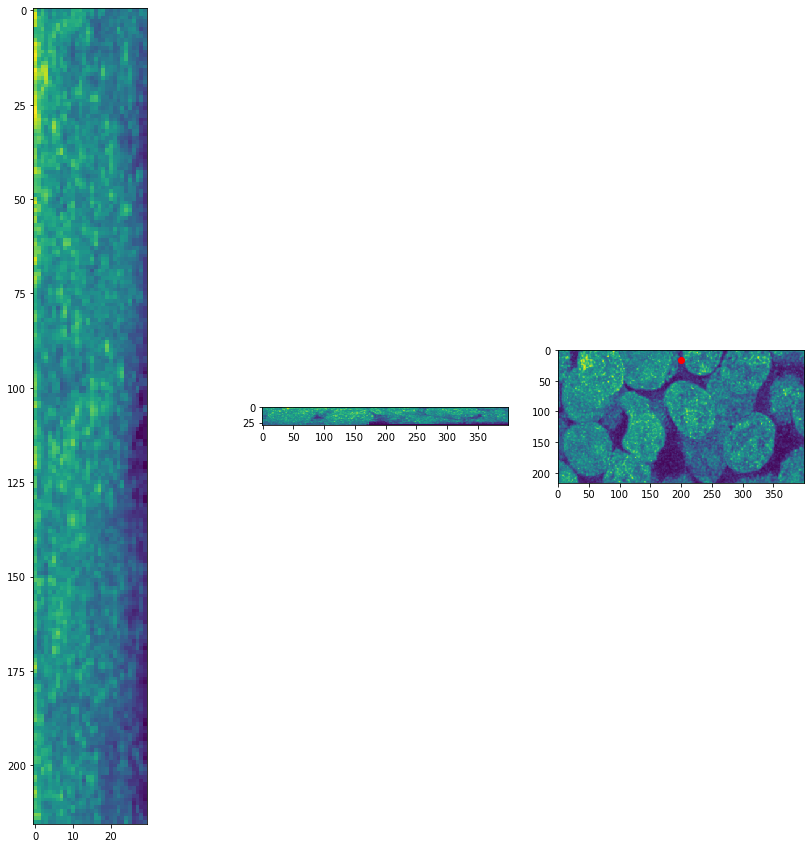

In [120]:
#example of bad centroid in wang lab's segmentation (i = 0) d13
show(input_gpu)

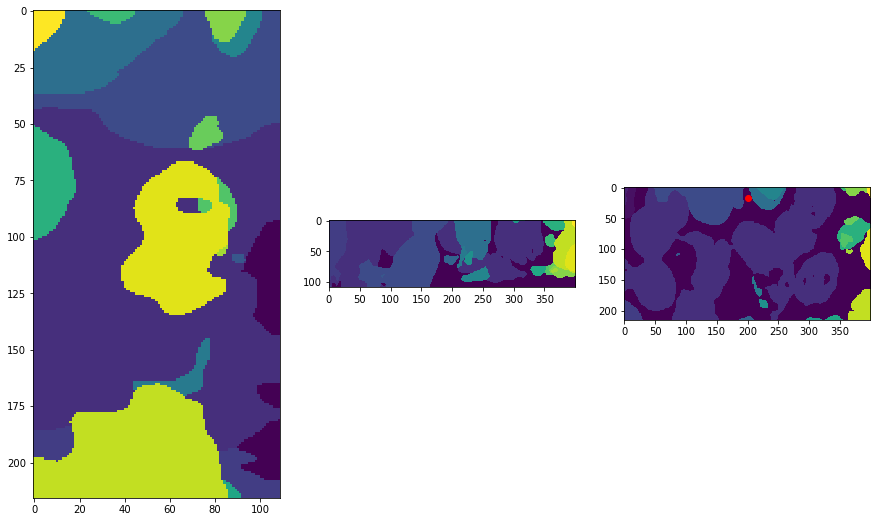

In [117]:
show(segmented)

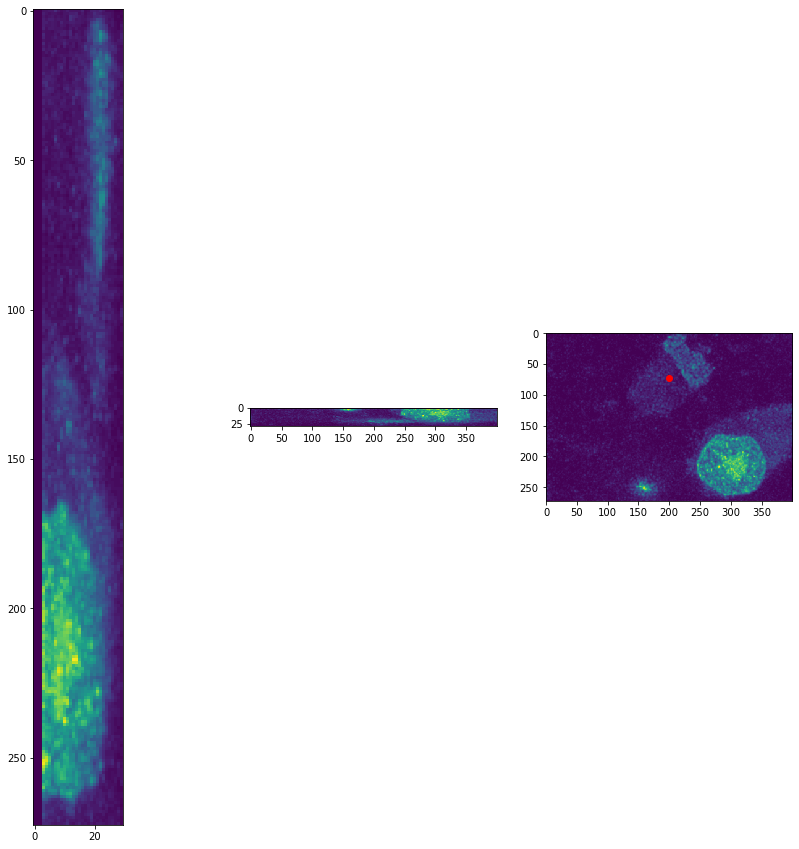

In [132]:
#example of cell not found (idx=9) d13 (73,200)
show(input_gpu)

In [184]:
resampled_erode=ndimage.grey_erosion(cp.array(resampled),structure=cp.ones((3,3,3)))
resampled_erode=ndimage.grey_dilation(cp.array(resampled_erode),structure=cp.ones((3,3,3)))

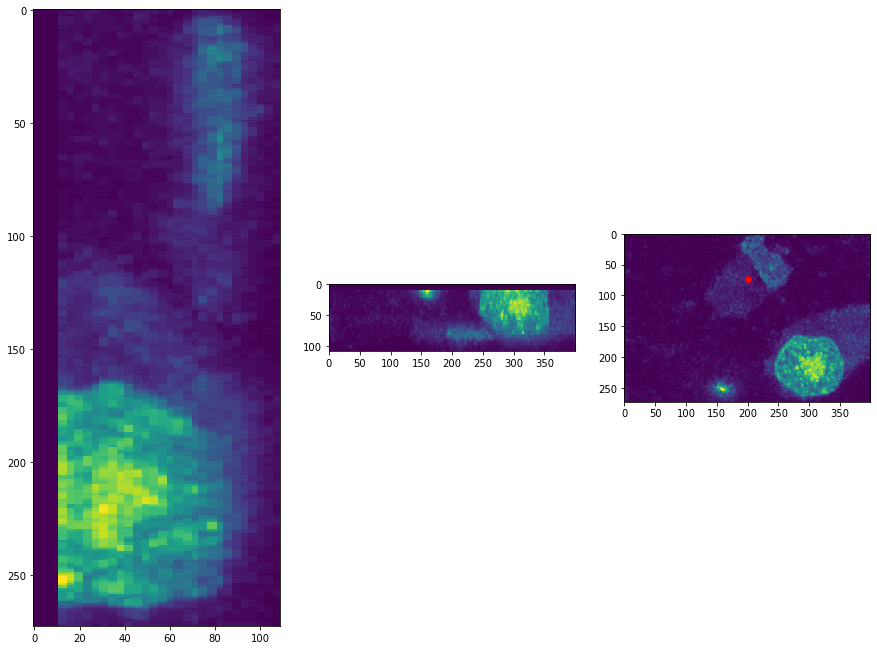

In [185]:
show(resampled_erode)

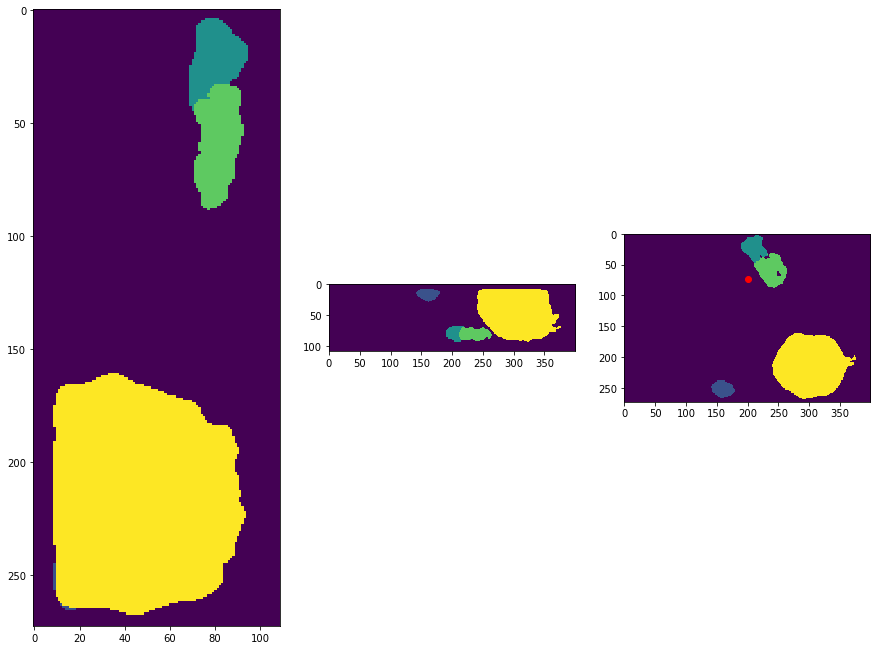

In [189]:

segmented = cle.voronoi_otsu_labeling(resampled, spot_sigma=10, outline_sigma=3)
show(segmented)

In [170]:
segmenteddilated=ndimage.grey_dilation(cp.array(segmented), structure=np.ones((3,3,3)))

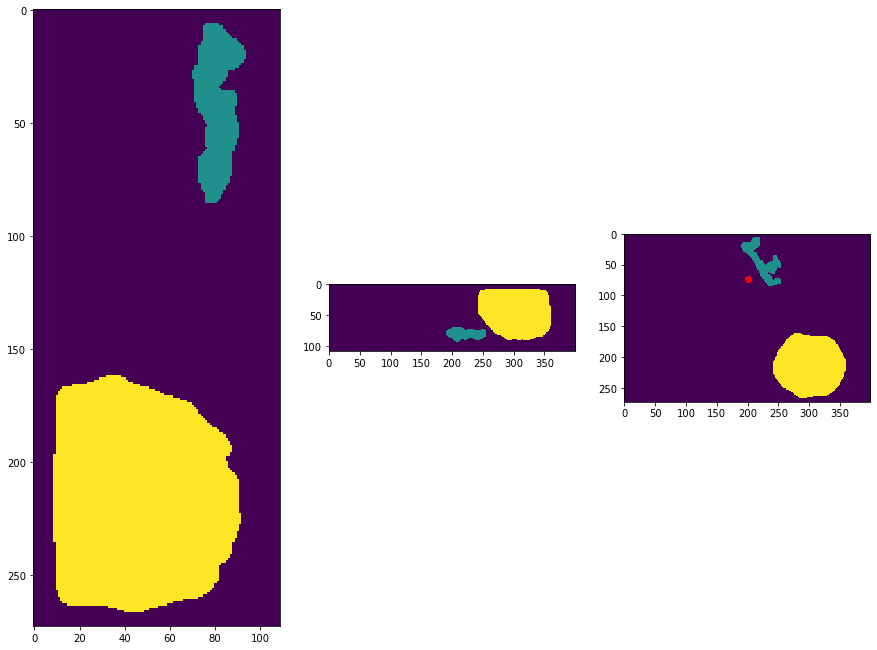

In [171]:
show(segmenteddilated)

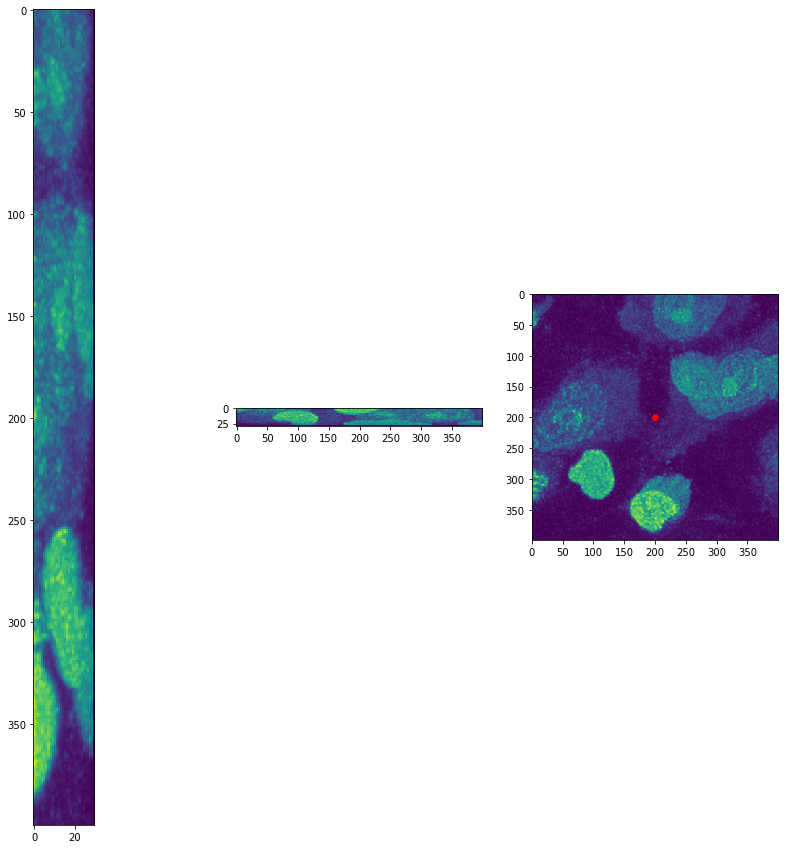

In [229]:
#another example of cell not found d13 (200,200)
testcoord=gaeCoord[9729]
testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

In [25]:
centroidy

200

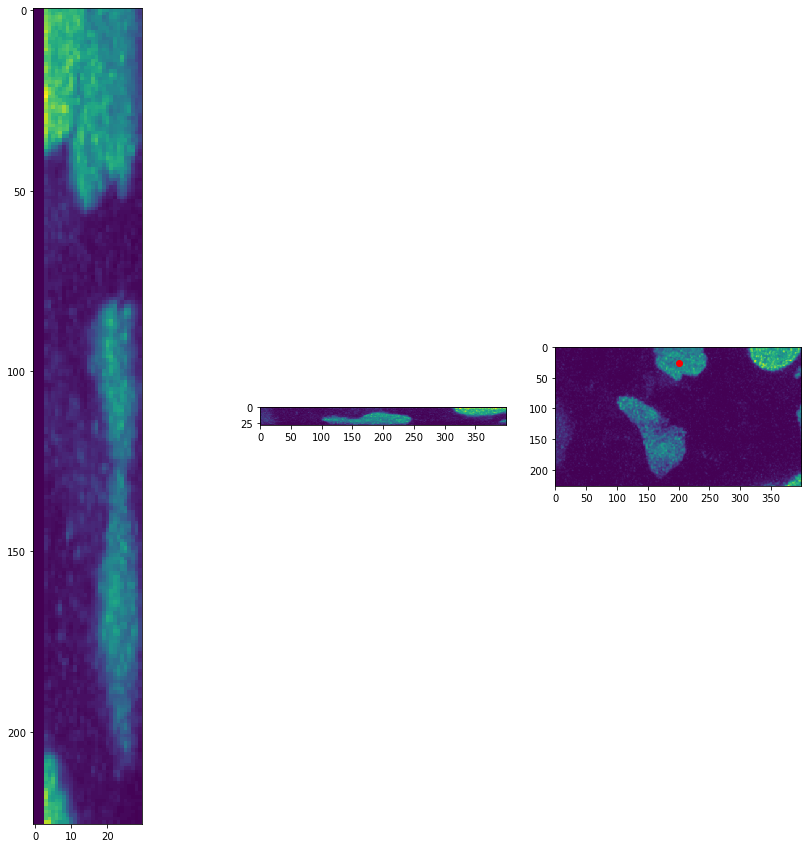

In [26]:
#idx=4 after minmax
testcoord=gaeCoord[4]

if testcoord[0]-cropsize<0:
    centroidx=testcoord[0]
else:
    centroidx=minmaxsize
if testcoord[1]-cropsize<0:
    centroidy=testcoord[1]
else:
    centroidy=minmaxsize

#     testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
testinput=img[:,max(0,testcoord[0]-minmaxsize):min(img.shape[1],testcoord[0]+minmaxsize),max(0,testcoord[1]-minmaxsize):min(img.shape[2],testcoord[1]+minmaxsize)]
testinput=(testinput-np.min(testinput))/(np.max(testinput)-np.min(testinput))
testinput=testinput[:,max(0,centroidx-cropsize):min(testinput.shape[1],centroidx+cropsize),max(0,centroidy-cropsize):min(testinput.shape[2],centroidy+cropsize)]
input_gpu = cle.push(testinput)

show(input_gpu)

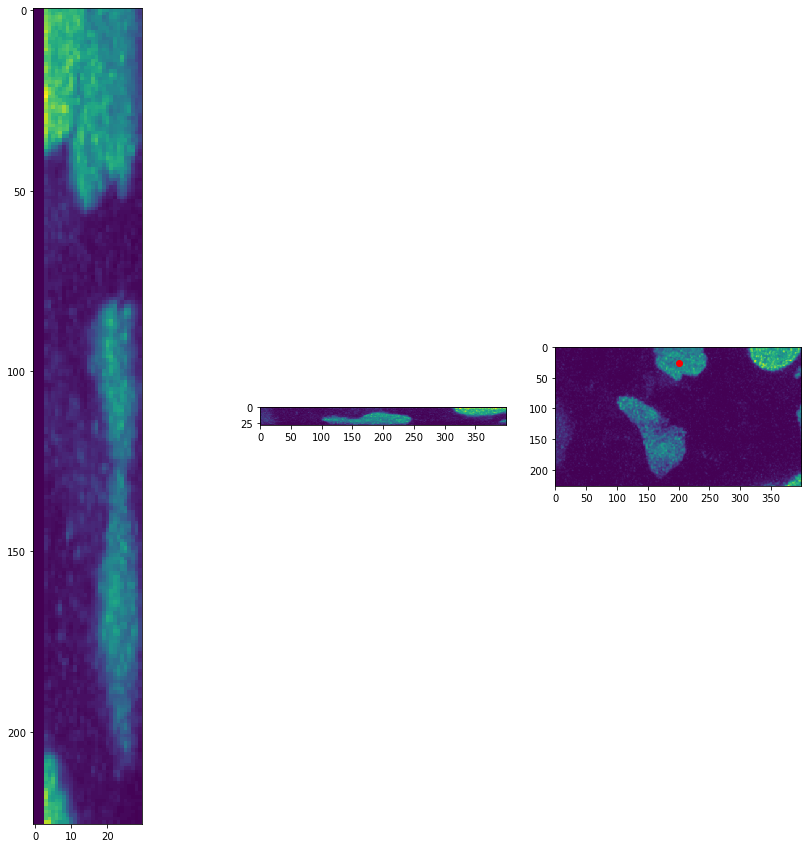

In [18]:
testcoord=gaeCoord[4]
testinput=img[:,max(0,testcoord[0]-cropsize):min(img.shape[1],testcoord[0]+cropsize),max(0,testcoord[1]-cropsize):min(img.shape[2],testcoord[1]+cropsize)]
input_gpu = cle.push(testinput)
show(input_gpu)

In [12]:
currstats= cle.statistics_of_labelled_pixels(resampled,segmented)

In [13]:
currstats=pd.DataFrame(currstats).to_numpy()

In [14]:
currstats

array([[1.00000000e+00, 1.00000000e+00, 1.68000000e+02, 1.60000000e+02,
        2.00000000e+00, 2.41000000e+02, 2.39000000e+02, 2.80000000e+01,
        7.40000000e+01, 8.00000000e+01, 2.70000000e+01, 0.00000000e+00,
        8.49557519e-01, 1.98624492e+04, 7.73680000e+04, 2.56726921e-01,
        3.97630800e+06, 2.00192230e+02, 3.96462175e+06, 1.99603867e+02,
        2.29710438e+05, 1.15650606e+01, 1.55083420e+07, 2.00449051e+02,
        1.54731180e+07, 1.99993774e+02, 9.48289000e+05, 1.22568636e+01,
        1.83846162e+06, 2.37625580e+01, 1.84032438e+06, 2.37866344e+01,
        1.25153825e-01, 4.34682388e+01, 4.36331558e+01, 1.82927442e+00,
        1.83435595e+00]])